# Simple Linear Regression
#### The normalization and splitting dataset into train and test sets are essential. However, in the case of this dataset, due to its small size, these steps were not performed.

## Import Libraries

In [215]:
import numpy as np
import pandas as pd
import torch
import optuna
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Prepare the dataset

### Load the dataset

In [216]:
data = pd.read_csv('sat_gpa.csv')
data

,SAT,GPA
0,1714,2.40
1,1664,2.52
2,1760,2.54
3,1685,2.74
4,1693,2.83
...,...,...
95,1934,3.54
96,1861,3.58
97,1931,3.58
98,1933,3.59


### Split the dataset

In [217]:
X = data['SAT'].values
y = data['GPA'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape', y_test.shape)

x_train shape: (80,)
y_train shape: (80,)
x_test shape: (20,)
y_test shape (20,)


### Normalize the dataset

In [218]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train.reshape(-1, 1))
x_test = x_scaler.transform(x_test.reshape(-1, 1))

y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

### Convert into Tensor

In [219]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

## Plot the dataset

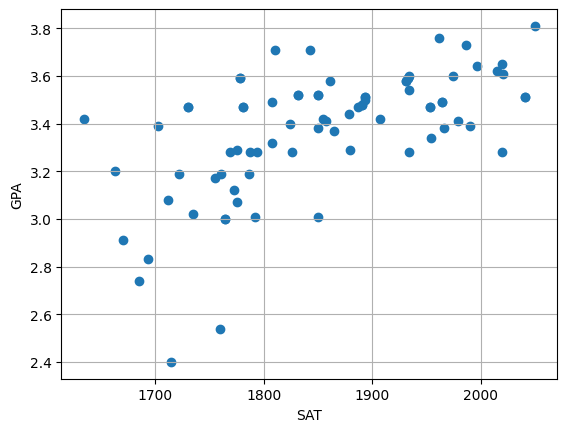

In [220]:
plt.scatter(x_scaler.inverse_transform(x_train), y_scaler.inverse_transform(y_train))
plt.grid(True)
plt.xlabel('SAT')
plt.ylabel('GPA')
plt.show()

## Functions to compute the models

### To optimize parameters using optuna

In [221]:
def objective(trial, X, y):
    num_epochs = trial.suggest_categorical('epoch_num', [100, 1000, 10000])
    lr = trial.suggest_categorical('lr', [0.1, 0.01, 0.001, 0.0001, 0.00001])

    # define paremeters
    W = torch.zeros(1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    cost = train_model(X, y, W, b, num_epochs, lr, True)

    trial.report(cost, num_epochs)
    print(f'Trial {trial.number} - Epoch: {num_epochs}, lr: {lr}, Cost: {cost}')

    return cost

### To train the model

In [222]:
def train_model(X, y, W, b, num_epochs, lr, check_optuna):
    # set optimizer
    optimizer = optim.SGD([W, b], lr=lr)

    costs = []
    for epoch in range(num_epochs):
        hypothesis = X * W + b
        cost = torch.mean((hypothesis - y) ** 2)

        if check_optuna == True:
            if torch.isnan(cost) or torch.isinf(cost):
                raise optuna.TrialPruned()
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if check_optuna == False:
            costs.append(cost.item())
            if epoch % (num_epochs // 10) == 0:
                print(f'Epoch: {epoch}/{num_epochs} - Cost: {cost.item()}')

    if check_optuna == False:
        return costs, hypothesis
    else:
        return cost.item()

## Study optuna

In [223]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, x_train, y_train), n_trials=30)

Trial 0 - Epoch: 1000, lr: 0.0001, Cost: 0.8788061141967773
Trial 1 - Epoch: 10000, lr: 1e-05, Cost: 0.8787263035774231
Trial 2 - Epoch: 1000, lr: 0.01, Cost: 0.6321200728416443
Trial 3 - Epoch: 10000, lr: 0.001, Cost: 0.6321201324462891
Trial 4 - Epoch: 100, lr: 0.001, Cost: 0.8796075582504272
Trial 5 - Epoch: 10000, lr: 0.1, Cost: 0.6321201324462891
Trial 6 - Epoch: 100, lr: 1e-05, Cost: 0.9985460042953491
Trial 7 - Epoch: 10000, lr: 0.01, Cost: 0.6321200728416443
Trial 8 - Epoch: 100, lr: 1e-05, Cost: 0.9985460042953491
Trial 9 - Epoch: 10000, lr: 0.01, Cost: 0.6321200728416443
Trial 10 - Epoch: 1000, lr: 0.01, Cost: 0.6321200728416443
Trial 11 - Epoch: 1000, lr: 0.01, Cost: 0.6321200728416443
Trial 12 - Epoch: 1000, lr: 0.01, Cost: 0.6321200728416443
Trial 13 - Epoch: 10000, lr: 0.01, Cost: 0.6321200728416443
Trial 14 - Epoch: 1000, lr: 0.1, Cost: 0.6321201324462891
Trial 15 - Epoch: 10000, lr: 0.0001, Cost: 0.6388581991195679
Trial 16 - Epoch: 1000, lr: 0.01, Cost: 0.6321200728416

## Best Parameters

In [224]:
best_params = study.best_params
print('Best parameters:', best_params)

best_epoch = best_params['epoch_num']
best_lr = best_params['lr']

Best parameters: {'epoch_num': 1000, 'lr': 0.01}


## Train the model with best parameters

In [225]:
W = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

costs, hypothesis = train_model(x_test, y_test, W, b, best_epoch, best_lr, False)

Epoch: 0/1000 - Cost: 0.896959662437439
Epoch: 100/1000 - Cost: 0.5242617130279541
Epoch: 200/1000 - Cost: 0.5110664963722229
Epoch: 300/1000 - Cost: 0.5103203058242798
Epoch: 400/1000 - Cost: 0.5102723836898804
Epoch: 500/1000 - Cost: 0.5102692246437073
Epoch: 600/1000 - Cost: 0.510269045829773
Epoch: 700/1000 - Cost: 0.5102689862251282
Epoch: 800/1000 - Cost: 0.5102689862251282
Epoch: 900/1000 - Cost: 0.510269045829773


## Plot the cost with epoch

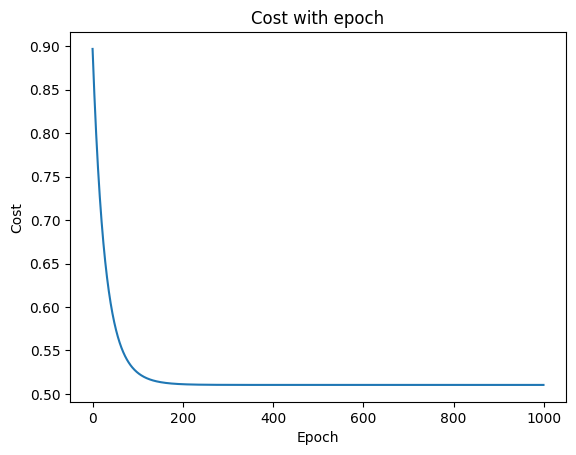

In [226]:
plt.plot(range(best_epoch), costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost with epoch')
plt.show()

## Plot the model

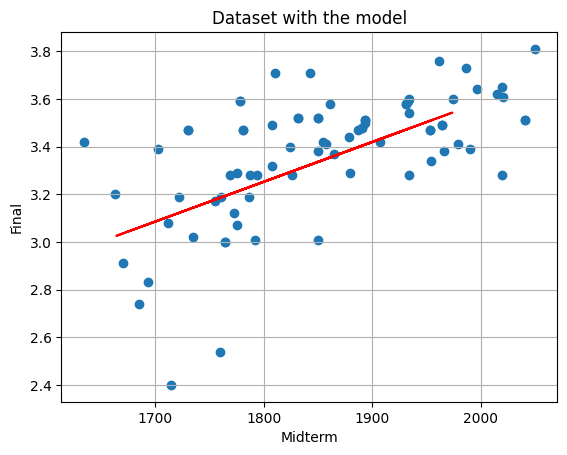

In [234]:
plt.scatter(x_scaler.inverse_transform(x_train), y_scaler.inverse_transform(y_train))
plt.plot(x_scaler.inverse_transform(x_test), y_scaler.inverse_transform(hypothesis.detach().numpy()), color='red')
plt.xlabel('Midterm')
plt.ylabel('Final')
plt.title('Dataset with the model')
plt.grid(True)
plt.show()

## Print trained W, b

In [235]:
print('Weights of the model:', W.item())
print('Bias of the model:', b.item())

Weights of the model: 0.6616544723510742
Bias of the model: -0.11214254051446915


## Plot loss graph

## Test the performance of the model